In [12]:
import pandas as pd 
import numpy as np
import random
import math
result = pd.read_csv('../data/1_before2016.csv').dropna()

X_seq = []
y_seq = []
for name, content in result.groupby('tic'):
    for i in range(len(content.index)-10):
        train_seq = []
        for j in range(i, i + 10):
            train_seq.append(result.iloc[j]['actual'])
        X_seq.append(train_seq)
        y_seq.append(result.iloc[i+10]['actual'])

X = pd.DataFrame(X_seq)
y = pd.DataFrame(y_seq)

result1 = pd.read_csv('../data/1_after2016.csv').dropna()

X_seq1 = []
y_seq1 = []
for name, content in result1.groupby('tic'):
    for i in range(len(content.index)-10):
        train_seq = []
        for j in range(i, i + 10):
            train_seq.append(result.iloc[j]['actual'])
        X_seq1.append(train_seq)
        y_seq1.append(result.iloc[i+10]['actual'])

X1 = pd.DataFrame(X_seq1)
y1 = pd.DataFrame(y_seq1)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

target = torch.tensor(y.values.astype(np.float32))
train = torch.tensor(X.values.astype(np.float32))
N = train.shape[0]
train_N = int(0.9*N)
valid_N = N - train_N

target1 = torch.tensor(y1.values.astype(np.float32))
train1 = torch.tensor(X1.values.astype(np.float32))

batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 50000

train_tensor = torch.utils.data.TensorDataset(train, target) 

test_dataset = torch.utils.data.TensorDataset(train1, target1)

train_dataset, valid_dataset = torch.utils.data.random_split(train_tensor, [train_N, valid_N])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size_test, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

In [18]:
## Now we can start to build our nn model
## We first import the pytorch nn module and optimizer

## Then define the model class
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        #fully connected layer
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


device = "cpu"
model = NN().to(device) #using cpu here

In [19]:
def withinten(y_true, y_pred):
    sum1 = 0
    for i in range(len(y_pred)):
        if(y_pred[i] < 1.1*y_true[i] and y_pred[i] > 0.9*y_true[i]):
            sum1+=1
    return sum1/len(y_pred)

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
##define train function
loss_fn = nn.MSELoss(reduction='mean')
trainloss = []
validloss = []
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    loss1 = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        loss1 += loss.item() * len(output)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    trainloss.append(loss1/train_N)

def validation(model, device, valid_loader):
    model.eval()
    with torch.no_grad():
        loss = 0
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += loss_fn(output, target).item() * len(output)
    validloss.append(loss/valid_N)
    print('Valid Loss: {:.3f}\n'.format(loss/valid_N))

##define test function
def test(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target).item()
            r2_nn0 = r2_score(target, output)
            within10 = withinten(target, output)
    return loss, r2_nn0, within10


In [21]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [22]:
num_epoch = 200
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)
    validation(model, device, valid_loader)

Train Epoch: 1 [0/16406 (0%)]	Loss: 1.139653
Train Epoch: 1 [6400/16406 (39%)]	Loss: 0.205442
Train Epoch: 1 [12800/16406 (78%)]	Loss: 0.057230
Valid Loss: 0.052

Train Epoch: 2 [0/16406 (0%)]	Loss: 0.043474
Train Epoch: 2 [6400/16406 (39%)]	Loss: 0.060811
Train Epoch: 2 [12800/16406 (78%)]	Loss: 0.040087
Valid Loss: 0.044

Train Epoch: 3 [0/16406 (0%)]	Loss: 0.056172
Train Epoch: 3 [6400/16406 (39%)]	Loss: 0.047455
Train Epoch: 3 [12800/16406 (78%)]	Loss: 0.051784
Valid Loss: 0.043

Train Epoch: 4 [0/16406 (0%)]	Loss: 0.065165
Train Epoch: 4 [6400/16406 (39%)]	Loss: 0.049660
Train Epoch: 4 [12800/16406 (78%)]	Loss: 0.035178
Valid Loss: 0.042

Train Epoch: 5 [0/16406 (0%)]	Loss: 0.039163
Train Epoch: 5 [6400/16406 (39%)]	Loss: 0.035464
Train Epoch: 5 [12800/16406 (78%)]	Loss: 0.039377
Valid Loss: 0.041

Train Epoch: 6 [0/16406 (0%)]	Loss: 0.041227
Train Epoch: 6 [6400/16406 (39%)]	Loss: 0.042234
Train Epoch: 6 [12800/16406 (78%)]	Loss: 0.040225
Valid Loss: 0.041

Train Epoch: 7 [0/1640

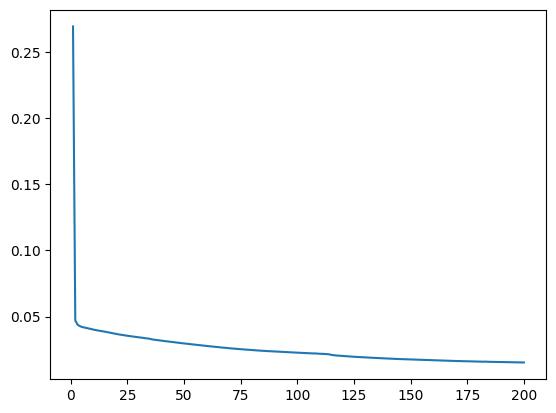

In [23]:
from matplotlib import pyplot as plt
plt.plot(range(1, 200+1), trainloss)
#plt.savefig('nn9_train.png')

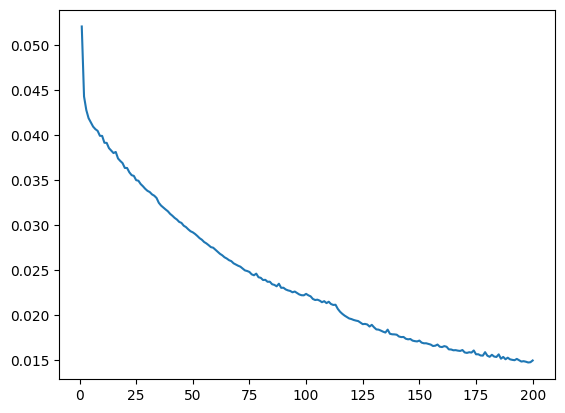

In [24]:
plt.plot(range(1, 200+1), validloss)
plt.savefig('nn9_valid.png')

In [25]:
loss, r2, within10 = test(model, device, test_loader)

print('Test Loss: {:.3f}'.format(np.mean(loss)))
print('R2: {:.3f}'.format(np.mean(r2)))
print('Within10%: {:.3f}'.format(np.mean(within10)))

Test Loss: 0.009
R2: 0.966
Within10%: 0.793
